# Project 4!!

In [621]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

%matplotlib inline

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

In [622]:
# Load dataset
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
weather_df = pd.read_csv('../dataset/weather_final.csv')
street_map = gpd.read_file('../map/geo_export_6f337adc-3081-4800-8a83-2e6ce1971179.shp')

### Map

In [623]:
train_df_copy = train_df.copy()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,POINT (-87.800991 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,POINT (-87.800991 41.95469)


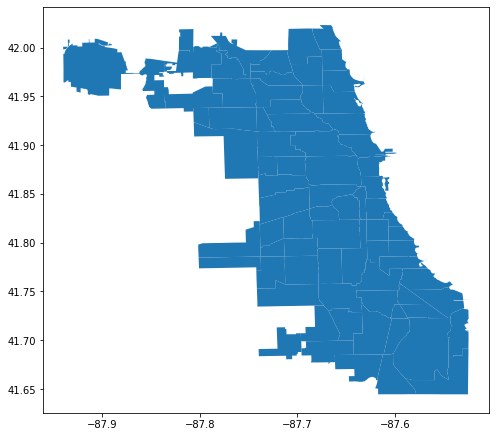

In [624]:
import geopandas as gpd
from shapely.geometry import Point, Polygon


fig, ax = plt.subplots(figsize=(8,8))
street_map.plot(ax = ax);

# Compile list of observation of each geo point
geometry = [Point(xy) for xy in zip(train_df['Longitude'], train_df['Latitude'])]
geometry[:3]

# Set up Chicago coordinates using EPSG coordinate ref. system
crs = {'init': 'epsg:4326'}

# Convert train dataframe to geo dataframe
geo_df = gpd.GeoDataFrame(train_df_copy,
                          crs = crs,
                          geometry = geometry)
geo_df.head(2)

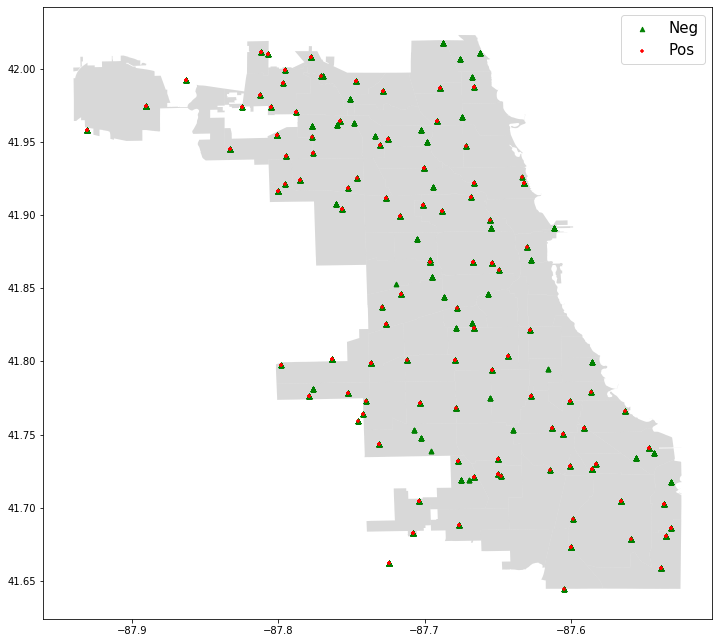

In [625]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=.3, color='grey');
geo_df[geo_df['WnvPresent'] == 0].plot(ax=ax, markersize=20, color='g', marker='^', label='Neg')
geo_df[geo_df['WnvPresent'] == 1].plot(ax=ax, markersize=20, color='r', marker='+', label='Pos')
plt.legend(prop={'size':15});

In [626]:
# Print shape of dataset
print(train_df.shape)
print(test_df.shape)

(10506, 12)
(116293, 11)


In [627]:
# Print columns
print(train_df.columns)
print(test_df.columns)

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')
Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')


In [628]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [629]:
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [630]:
train_df[train_df.duplicated()]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
512,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10013,2013-08-29,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,50,1
10102,2013-09-06,"3700 South Pulaski Road, Chicago, IL 60623, USA",CULEX PIPIENS,37,S PULASKI RD,T063,"3700 S PULASKI RD, Chicago, IL",41.825610,-87.726549,9,9,0
10124,2013-09-06,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,1
10262,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0


In [631]:
print(train_df[train_df.duplicated()].count())

Date                      813
Address                   813
Species                   813
Block                     813
Street                    813
Trap                      813
AddressNumberAndStreet    813
Latitude                  813
Longitude                 813
AddressAccuracy           813
NumMosquitos              813
WnvPresent                813
dtype: int64


In [632]:
print(test_df[test_df.duplicated()].count())

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64


In [633]:
train_df.groupby(by=['Date','Address','Species','WnvPresent']).sum()

Block  \
Date       Address                                            Species                WnvPresent          
2007-05-29 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS/RESTUANS 0              11   
                                                              CULEX RESTUANS         0              11   
           1100 South Peoria Street, Chicago, IL 60608, USA   CULEX RESTUANS         0              11   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0              11   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0              15   
...                                                                                                ...   
2013-09-26 South Stony Island Avenue, Chicago, IL, USA        CULEX PIPIENS          0              10   
                                                              CULEX PIPIENS/RESTUANS 0              10   
           South Vincennes Avenue, Chicago, IL, USA           CULEX PIPIENS/RESTUANS 0              10   
           University of Illinois at Chicago, 1100 South A... CULEX PIPIENS/RESTUANS 0              11   
           West Garfield Boulevard, Chicago, IL, USA          CULEX PIPIENS/RESTUANS 0              90   

                                                                                                  Latitude  \
Date       Address                                            Species                WnvPresent              
2007-05-29 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS/RESTUANS 0           41.867108   
                                                              CULEX RESTUANS         0           41.867108   
           1100 South Peoria Street, Chicago, IL 60608, USA   CULEX RESTUANS         0           41.862292   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0           41.896282   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0           41.907645   
...                                                                                                    ...   
2013-09-26 South Stony Island Avenue, Chicago, IL, USA        CULEX PIPIENS          0           41.726465   
                                                              CULEX PIPIENS/RESTUANS 0           41.726465   
           South Vincennes Avenue, Chicago, IL, USA           CULEX PIPIENS/RESTUANS 0           41.723195   
           University of Illinois at Chicago, 1100 South A... CULEX PIPIENS/RESTUANS 0           41.868077   
           West Garfield Boulevard, Chicago, IL, USA          CULEX PIPIENS/RESTUANS 0           41.793818   

                                                                                                 Longitude  \
Date       Address                                            Species                WnvPresent              
2007-05-29 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS/RESTUANS 0          -87.654224   
                                                              CULEX RESTUANS         0          -87.654224   
           1100 South Peoria Street, Chicago, IL 60608, USA   CULEX RESTUANS         0          -87.648860   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0          -87.655232   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0          -87.760886   
...                                                                                                    ...   
2013-09-26 South Stony Island Avenue, Chicago, IL, USA        CULEX PIPIENS          0          -87.585413   
                                                              CULEX PIPIENS/RESTUANS 0          -87.585413   
           South Vincennes Avenue, Chicago, IL, USA           CULEX PIPIENS/RESTUANS 0          -87.649970   
           University of Illinois at Chicago, 1100 South A... CULEX PIPIENS/R

In [634]:
# Drop duplicates
train_df.drop_duplicates(subset=['Date','Address','Species','Trap','Block','WnvPresent'],inplace=True)
train_df.reset_index(inplace=True)

In [635]:
train_df.shape

(8610, 13)

In [636]:
# Check which mozzies spread WNV
train_df[train_df['WnvPresent'] == 1]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

In [637]:
# Check if there's overlap
train_df[train_df['WnvPresent'] == 0]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [638]:
train_df[['Species', 'NumMosquitos']].head(20)

,Species,NumMosquitos
0,CULEX PIPIENS/RESTUANS,1
1,CULEX RESTUANS,1
2,CULEX RESTUANS,1
3,CULEX PIPIENS/RESTUANS,1
4,CULEX RESTUANS,4
5,CULEX RESTUANS,2
6,CULEX RESTUANS,1
7,CULEX PIPIENS/RESTUANS,1
8,CULEX RESTUANS,2
9,CULEX RESTUANS,1


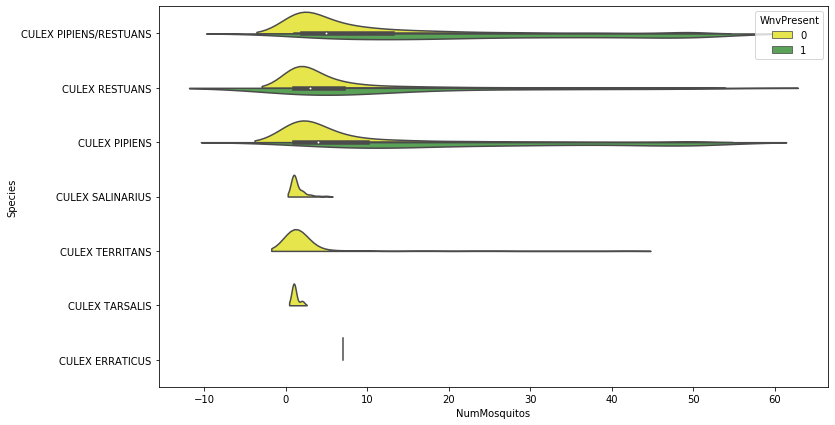

In [639]:
plt.figure(figsize=(12,7))
sns.violinplot(y="Species", x="NumMosquitos", hue="WnvPresent", data=train_df, split=True, palette="Set1_r");

In [640]:
# # Find probability of ocurrence for each mosquito
# prob_1 = train_df[train_df['Species'] == 'CULEX PIPIENS/RESTUANS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX PIPIENS/RESTUANS']['WnvPresent'].count()
# prob_2 = train_df[train_df['Species'] == 'CULEX PIPIENS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX PIPIENS']['WnvPresent'].count()
# prob_3 = train_df[train_df['Species'] == 'CULEX RESTUANS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX RESTUANS']['WnvPresent'].count()

In [641]:
# # Ordinal encode species
# ord_list = []
# for i in train_df['Species']:
#     if i == 'CULEX PIPIENS/RESTUANS':
#         ord_list.append(prob_1)
#     elif i == 'CULEX PIPIENS':
#         ord_list.append(prob_2)
#     elif i == 'CULEX RESTUANS':
#         ord_list.append(prob_3)
#     else:
#         ord_list.append(0)

# train_df['Species_Enc'] = ord_list

In [642]:
# # Ordinal encode species
# ord_list = []
# for i in test_df['Species']:
#     if i == 'CULEX PIPIENS/RESTUANS':
#         ord_list.append(2)
#     elif i == 'CULEX PIPIENS':
#         ord_list.append(3)
#     elif i == 'CULEX RESTUANS':
#         ord_list.append(1)
#     else:
#         ord_list.append(0)

# test_df['Species_Enc'] = ord_list

In [643]:
# One-hot encode mozzies that spread WNV
train_species = pd.get_dummies(train_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
test_species = pd.get_dummies(test_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]

In [644]:
train_df = pd.concat([train_df,train_species],axis=1,sort=False)
test_df = pd.concat([test_df,test_species],axis=1,sort=False)

In [645]:
# Calculate euclidean distance of weather station from city and determine which station is nearest
# This is calculated using pythagoras theorem  
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
train_df['diststat1'] = np.sqrt((train_df['Latitude'] - 41.995) ** 2 + (train_df['Longitude'] - (-87.933)) ** 2)
train_df['diststat2'] = np.sqrt((train_df['Latitude'] - 41.786) ** 2 + (train_df['Longitude'] - (-87.752)) ** 2)
train_df['Station'] = [2 if train_df['diststat1'][i] > train_df['diststat2'][i] else 1 for i in range(train_df.shape[0])]
train_df.head()

,index,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,1,0,0,0.138026,0.175660,1
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,0,1,0.138026,0.175660,1
2,2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,1,0.163721,0.209704,1
3,3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,1,0,0,0.110190,0.201691,1
4,4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,0,0,1,0.110190,0.201691,1


In [646]:
# Apply for test data set
test_df['diststat1'] = np.sqrt((test_df['Latitude'] - 41.995) ** 2 + (test_df['Longitude'] - (-87.933)) ** 2)
test_df['diststat2'] = np.sqrt((test_df['Latitude'] - 41.786) ** 2 + (test_df['Longitude'] - (-87.752)) ** 2)
test_df['Station'] = [2 if test_df['diststat1'][i] > test_df['diststat2'][i] else 1 for i in range(test_df.shape[0])]
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,0.138026,0.17566,1
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,1,0.138026,0.17566,1
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,1,0,0.138026,0.17566,1
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0.138026,0.17566,1
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0.138026,0.17566,1


In [647]:
train_df['dateofyear'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d').dt.dayofyear
test_df['dateofyear'] = pd.to_datetime(test_df['Date'], format='%Y-%m-%d').dt.dayofyear

In [648]:
# Merged weather and train/test to one dataframe
train_weather_df = pd.merge(train_df,weather_df,on=['Station','Date'])
train_weather_df.drop(axis=1,columns=['index'],inplace=True)
train_weather_df.head()
train_weather_df.to_csv('../dataset/train_weather.csv')

In [649]:
test_weather_df = pd.merge(test_df,weather_df,on=['Station','Date'])
# test_weather_df.drop(axis=1,columns=['Water1','Depth'],inplace=True)
test_weather_df.head()
train_weather_df.to_csv('../dataset/test_weather.csv')

In [650]:
train_weather_df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
CULEX PIPIENS/RESTUANS      uint8
CULEX PIPIENS               uint8
CULEX RESTUANS              uint8
diststat1                 float64
diststat2                 float64
Station                     int64
dateofyear                  int64
Tmax                        int64
Tmin                        int64
Tavg                      float64
Depart                    float64
DewPoint                    int64
WetBulb                   float64
Heat                      float64
Cool                      float64
Sunrise                     int64
Sunset                      int64
CodeSum       

In [651]:
## Label encode the Species column
encoder = LabelEncoder()
encoder.fit(train_weather_df['Species'].values.tolist() + test_weather_df['Species'].values.tolist())
train_weather_df['Species'] = encoder.transform(train_weather_df['Species'].values)
test_weather_df['Species'] = encoder.transform(test_weather_df['Species'].values)

In [652]:
np.abs(train_weather_df.corr()[['WnvPresent']]).sort_values(by=['WnvPresent'],ascending=False).head(25)

,WnvPresent
WnvPresent,1.000000
NumMosquitos,0.298589
Species,0.114687
dateofyear,0.100332
Month,0.096551
Sunrise,0.096179
CULEX PIPIENS,0.095826
CULEX RESTUANS,0.092170
DewPoint,0.088540
WetBulb,0.087747


In [653]:
# # Get the correleation

# corr = train_weather_df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 20))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation')

In [654]:
#feat = ['dateofyear', 'Year', 'AddressAccuracy','Species','Heat','Cool','WetBulb','Station','Tmin','Tmax','DewPoint']
feat = ['Species', 'dateofyear', 'Month', 'Sunrise', 'WetBulb', 'DewPoint', 'Station', 'Sunset', 'Station', 'Tavg', 'Heat', 'Cool', 'Depart']

X_subset = train_weather_df[feat]
#y = train_weather_df['WnvPresent']
X_kaggle_subset = test_weather_df[feat]

In [655]:
X_subset.head()

,Species,dateofyear,Month,Sunrise,WetBulb,DewPoint,Station,Sunset,Station,Tavg,Heat,Cool,Depart
0,2,149,5,421,65.0,58,1,1917,1,74.0,0.0,9.0,10.0
1,3,149,5,421,65.0,58,1,1917,1,74.0,0.0,9.0,10.0
2,3,149,5,421,65.0,58,1,1917,1,74.0,0.0,9.0,10.0
3,2,149,5,421,65.0,58,1,1917,1,74.0,0.0,9.0,10.0
4,3,149,5,421,65.0,58,1,1917,1,74.0,0.0,9.0,10.0


In [656]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_subset)
X_kaggle_poly = poly.fit_transform(X_kaggle_subset)

In [657]:
poly_train = pd.DataFrame(X_train_poly, columns = poly.get_feature_names(X_subset.columns))
poly_kaggle = pd.DataFrame(X_kaggle_poly, columns = poly.get_feature_names(X_kaggle_subset.columns))

In [658]:
poly_train['WnvPresent'] = train_weather_df['WnvPresent']

In [659]:
features = np.abs(poly_train.corr()[['WnvPresent']]).sort_values(by='WnvPresent',ascending=False).head(31).T

In [660]:
features.columns.tolist()

['WnvPresent',
 'Sunrise WetBulb',
 'dateofyear DewPoint',
 'Sunrise DewPoint',
 'dateofyear WetBulb',
 'Month DewPoint',
 'Month WetBulb',
 'Sunrise Tavg',
 'dateofyear Tavg',
 'Species Station',
 'Species Station',
 'Month Tavg',
 'Sunrise Sunset',
 'Species Sunset',
 'dateofyear Sunset',
 'Species',
 'Month Sunset',
 'dateofyear',
 'Species Tavg',
 'Month',
 'Sunrise',
 'Species Sunrise',
 'Species WetBulb',
 'dateofyear Sunrise',
 'Month Sunrise',
 'dateofyear Month',
 'Species DewPoint',
 'dateofyear Cool',
 'WetBulb DewPoint',
 'DewPoint',
 'Station Sunset']

In [662]:
# feature_list = [
#                 'dateofyear CULEX PIPIENS/RESTUANS',
#                 'dateofyear CULEX PIPIENS',
#                 'dateofyear CULEX RESTUANS',
#                 'Latitude CULEX PIPIENS/RESTUANS',
#                 'Latitude CULEX PIPIENS',
#                 'Latitude CULEX RESTUANS',
#                 'Longitude CULEX PIPIENS/RESTUANS', 
#                 'Longitude CULEX PIPIENS',
#                 'Longitude CULEX RESTUANS',              
#                'WetBulb','Sunrise','Sunset','Tmin','Tmax','DewPoint']

# feature_list = ['WetBulb Sunrise',
#                'dateofyear DewPoint',
#                'Sunrise DewPoint',
#                'Sunrise Tmin',
#                'dateofyear Tmin',
#                'Sunrise Sunset',
#                'dateofyear Tmax',
#                'Sunrise Tmax',
#                'dateofyear Sunset']

# feature_list = [
#                 'dateofyear CULEX PIPIENS/RESTUANS',
#                 'dateofyear CULEX PIPIENS',
#                 'dateofyear CULEX RESTUANS',
#                 'CULEX PIPIENS/RESTUANS Sunrise',
#                 'CULEX PIPIENS Sunrise',
#                 'CULEX RESTUANS Sunrise',
#                 'Longitude CULEX PIPIENS/RESTUANS', 
#                 'Longitude CULEX PIPIENS',
#                 'Longitude CULEX RESTUANS',              
#                'WetBulb Sunrise','Sunrise']


# feature_list = [
#  'WetBulb Sunrise',
#  'dateofyear DewPoint',
#  'Sunrise DewPoint',
#  'dateofyear WetBulb',
#  'Sunrise Tmin',
#  'dateofyear Tmin',
#  'Species Station',
#  'Sunrise Sunset',
#  'dateofyear Tmax',
#  'Species Sunset',
#  'Sunrise Tmax',
#  'dateofyear Sunset',
#  'Species',
#  'Longitude Species',
#  'AddressAccuracy Species',
#  'dateofyear Longitude',
#  'dateofyear',
#  'Species Tmax',
#  'Longitude Sunrise',
#  'Sunrise',
#  'Species Sunrise',
#  'Species WetBulb',
#  'Species Tmin',
#  'dateofyear Sunrise',
#  'Species DewPoint',
#  'dateofyear Cool',
#  'WetBulb DewPoint',
#  'Longitude DewPoint',
#  'DewPoint',
#  'Station Sunset']
### Score: 0.76


# feature_list = ['WetBulb Sunrise',
#  'dateofyear DewPoint',
#  'Sunrise DewPoint',
#  'dateofyear WetBulb',
#  'Sunrise Tmin',
#  'dateofyear Tmin',
#  'Species Station',
#  'Sunrise Sunset',
#  'dateofyear Tmax',
#  'Species Sunset',
#  'Sunrise Tmax',
#  'dateofyear Sunset',
#  'Species',
#  'AddressAccuracy Species',
#  'dateofyear',
#  'Species Tmax',
#  'Sunrise',
#  'Species Sunrise',
#  'Species WetBulb',
#  'Species Tmin',
#  'dateofyear Sunrise',
#  'Species DewPoint',
#  'dateofyear Cool',
#  'WetBulb DewPoint',
#  'DewPoint',
#  'Station Sunset',
#  'WetBulb',
#  'Tmin DewPoint',
#  'Cool Sunrise',
#  'WetBulb Tmin']
### Score: 0.75

# feature_list = ['Sunrise WetBulb',
#  'dateofyear DewPoint',
#  'Sunrise DewPoint',
#  'dateofyear WetBulb',
#  'Month DewPoint',
#  'Month WetBulb',
#  'Sunrise Tavg',
#  'dateofyear Tavg',
#  'Month Tavg',
#  'Sunrise Sunset',
#  'Species Sunset',
#  'dateofyear Sunset',
#  'Species',
#  'Month Sunset',
#  'dateofyear',
#  'Species Tavg',
#  'Month',
#  'Sunrise',
#  'Species Sunrise',
#  'Species WetBulb',
#  'dateofyear Sunrise',
#  'Month Sunrise',
#  'dateofyear Month',
#  'Species DewPoint',
#  'dateofyear Cool',
#  'DewPoint WetBulb',
#  'DewPoint',
#  'WetBulb',
#  'Month Cool',
#  'Sunrise Cool']
# ## Score = .76

feature_list = ['Sunrise WetBulb',
 'dateofyear DewPoint',
 'Sunrise DewPoint',
 'dateofyear WetBulb',
 'Month DewPoint',
 'Month WetBulb',
 'Sunrise Tavg',
 'dateofyear Tavg',
 'Species Station',
 'Species Station',
 'Month Tavg',
 'Sunrise Sunset',
 'Species Sunset',
 'dateofyear Sunset',
 'Species',
 'Month Sunset',
 'dateofyear',
 'Species Tavg',
 'Month',
 'Sunrise',
 'Species Sunrise',
 'Species WetBulb',
 'dateofyear Sunrise',
 'Month Sunrise',
 'dateofyear Month',
 'Species DewPoint',
 'dateofyear Cool',
 'WetBulb DewPoint',
 'DewPoint',
 'Station Sunset']

X = poly_train[feature_list]
# y = train_weather_df['WnvPresent']
X_kaggle = poly_kaggle[feature_list]

In [663]:
model_dict = {
    'ss': StandardScaler(),
    'lr': LogisticRegression(solver='lbfgs'),
    'nb': MultinomialNB(),
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'et': ExtraTreesClassifier(),
    'ada_dt': AdaBoostClassifier(),
    'ada_rf': AdaBoostClassifier(base_estimator=RandomForestClassifier()),
    'gboost': GradientBoostingClassifier()
}

model_full = {
    'ss': 'Standard Scaler',
    'lr': 'Logistic Regression',
    'knn': 'KNearestNeighbor',
    'nb': 'Multinomial NB',
    'dt': 'Decision Tree',
    'rf': 'Random Forest',
    'et': 'Extra Tree',
    'ada_dt': 'AdaBoost - Decision Tree',
    'ada_rf': 'AdaBoost - Random Forest',
    'gboost': 'Gradient Boosting Classifier'
}

param_dict = {    
    'knn': {
        'knn__n_neighbors': [2,3,4,5]
    },
    'lr': {
        'lr__max_iter': [100,200]
    },
    'nb': {},
    'dt': {
        'dt__max_depth': [5,7],
        'dt__min_samples_split': [10,15],
        'dt__min_samples_leaf': [3,4]
    },
    'rf': {
        'rf__n_estimators': [500,1000,2000],
        'rf__min_samples_split': [2,3],
        'rf__max_depth': [2,3],
        'rf__min_samples_leaf': [3,4]
        
    },
    'et': {
        'et__n_estimators': [1000,2000],
        'et__min_samples_split': [2,3],
    },
    'ada_dt': {
        'ada_dt__n_estimators': [150,200,250,300,400],
        'ada_dt__learning_rate': [0.8, 0.9, 1.0, 1.1]
    },
    'ada_rf': {
        'ada_rf__n_estimators': [50,100,200],
        'ada_rf__learning_rate': [0.9, 1],
        'ada_rf__base_estimator__max_depth': [3], 
        'ada_rf__base_estimator__min_samples_leaf': [4], 
        'ada_rf__base_estimator__min_samples_split': [2], 
        'ada_rf__base_estimator__n_estimators': [1000]
    },
    'gboost': {
        'gboost__n_estimators': [100, 120, 150, 180, 200],
        'gboost__max_depth': [3,4,5],
        'gboost__learning_rate': [0.1, 0.5, 1]
    }
}

def prepare_pipeline(list_of_models):
    """
    Prepare pipeline of models to be used for modelling
    
    Parameters
    ----------
    list_of_models: list[str]
        List of models to be included for pipeline
    
    Returns
    -------
    Pipeline
        Pipeline of models to be run
    """
    pipe_list = [(i, model_dict[i]) for i in list_of_models]
    return Pipeline(pipe_list)


def add_params(name,pipe_dict):
    """
    Add parameters for GridSearch
    
    Parameters
    ----------
    name: str
        Name of model/vectorization method to have params added.
    pipe_dict: Dictionary
        Dictionary that contains parameters to be added into GridSearch
    
    Returns
    -------
    Dictionary
        Dictionary that contains parameters to be added for GridSearch
    """
    params = param_dict[name]
    for k,v in params.items():
        pipe_dict[k] = v
    return pipe_dict


def grid_search(model, train_data=X, train_target=y):
    """
    Initialize and run GridSearch
    
    Parameters
    ----------
    model: str
        Initialize which classification model to use. Note classification model has to be contained in model_dict.
        
    train_data: list[str]
        List of training data to be used
    
    Returns
    -------
    List
        List that contains predicted values of the test data
    """
    X_train, X_test, y_train, y_test = train_test_split(train_data,
                                                        y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=42)
    pipe_params = {}
    pipe_params = add_params(model, pipe_params)
    
    pipe = prepare_pipeline(['ss', model])
    
    gs = GridSearchCV(pipe,
                      param_grid=pipe_params,
                      cv=3,
                      n_jobs=-1,
                      scoring='roc_auc')
    gs.fit(X_train,y_train)
     
    print(f'Using {model_full[model]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')

In [664]:
# Function to fit full data and predict kaggle target, store as csv
def predict_kaggle(model, output, X=X, y=y, X_kaggle=X_kaggle):
    model.fit(X, y)
    pred = model.predict_proba(X_kaggle)[:,1]
    pred_df = pd.DataFrame({'Id':test_weather_df['Id'],
                            'WnvPresent': pred})
    
    # Export to CSV
    pred_df.to_csv('../KaggleSubmission/'+ output +'.csv', index=False)

In [666]:
grid_search('ada_dt')

Using AdaBoost - Decision Tree:
Train Score: 0.8159
Test Score: 0.851
Using the following parameters: {'ada_dt__learning_rate': 0.9, 'ada_dt__n_estimators': 200}


In [667]:
ada_dt = AdaBoostClassifier(learning_rate=0.9, n_estimators=200)
ada_dt.fit(X, y)

rfecv = RFECV(estimator=ada_dt,
              step=5,
              min_features_to_select=5,
              cv=10,
              scoring='roc_auc')

rfecv.fit(X, y)

print('Optimal number of features (after applying RFECV): {}'.format(rfecv.n_features_))

Optimal number of features (after applying RFECV): 17


In [668]:
# Create dataframe for RFECV features
rfecv_df = pd.DataFrame(data=rfecv.ranking_.reshape(-1,1), 
                        index=X.columns, 
                        columns=['Rank'])

# Create list of selected features that have the highest rank (rank equals 1)
final_features = rfecv_df[rfecv_df['Rank'] == 1].index.tolist()

In [669]:
final_features

['dateofyear DewPoint',
 'Sunrise DewPoint',
 'dateofyear WetBulb',
 'Month DewPoint',
 'dateofyear Tavg',
 'Month Tavg',
 'Sunrise Sunset',
 'Species Sunset',
 'Month Sunset',
 'Species Tavg',
 'Species Sunrise',
 'Species WetBulb',
 'dateofyear Sunrise',
 'Species DewPoint',
 'dateofyear Cool',
 'WetBulb DewPoint',
 'Station Sunset']

In [671]:
X = poly_train[final_features]
X_kaggle = poly_kaggle[final_features]

In [672]:
grid_search('ada_dt')

Using AdaBoost - Decision Tree:
Train Score: 0.8159
Test Score: 0.851
Using the following parameters: {'ada_dt__learning_rate': 0.9, 'ada_dt__n_estimators': 200}


In [673]:
predict_kaggle(AdaBoostClassifier(learning_rate=0.9, n_estimators=200),'ada_prediction_12')

In [674]:
grid_search('gboost')

Using Gradient Boosting Classifier:
Train Score: 0.8174
Test Score: 0.8506
Using the following parameters: {'gboost__learning_rate': 0.1, 'gboost__max_depth': 3, 'gboost__n_estimators': 100}


In [675]:
predict_kaggle(GradientBoostingClassifier(n_estimators=100,max_depth=3,learning_rate=0.1),'gboost_prediction6')